# MCMC - Importance sampling

Implementation of the equations found in [Importance Sampling](https://www.youtube.com/watch?v=TNZk8lo4e-Q&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=20)

\begin{align*}
p( \mathbf y | \mathbf X, \mathbf\theta) &= \Pi_i \mathrm {Ber} (y_i | \mathrm {sigm} (x_i, \mathbf \theta) ) \\
         &= \Pi_i \Big[ \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big]^{y_i} \Big[ 1 - \frac 1 {1+e^{- \mathbf x_i \mathbf \theta}} \Big]^{1 - y_i}
\end{align*}



Also, we assume a Gaussian prior ...

\begin{align*}
p(\theta) = \frac {1} {\sqrt {2 \pi \sigma ^2}} \exp \Big(-\frac 1 {2\sigma^2} (\theta-\mu)'(\theta-\mu) \Big)
\end{align*}

Then, we shall be able to find the posterior using:

\begin{align*}
p(\theta | \mathbf X, \mathbf y) = \frac 1 Z p(\mathbf y | \mathbf X, \theta) p(\theta)
\end{align*}

Note that we are trying to maximize this function (or alternatively minimizing the $-\log$ of this function). Taking the negative log of this function, we get ...

\begin{align*}
J(\theta) = -log(p(\theta| \mathbf X, \mathbf y)) &= \mathrm {const} - \log p(\mathbf y| \mathbf X, \theta) - \log p (\theta) \\
 &= \mathrm {const} - \Sigma_i [ y_i \log{\pi_i} + (1-y_i)\log( 1 - \pi_i ) ]  \frac 1 {2 \sigma ^2} || \theta ||_2 ^2
\end{align*}

In the case wherein we want a single value of $\theta$, we shall be doing gradient decent. However, we dont want to find a single value of theta, bur rather a meaningful distribution of theta. For that, we need to use some form of numerical technique. This is what we are going to do next.

Note that the calculation of $Z$ is unknown and hard. Also note that $Z$ is independent of $\theta$

\begin{align*}
Z &= \int p(\mathbf y|\mathbf X, \theta) p(\theta) d\theta \\
  &= \int \frac {p(\mathbf y|\mathbf X, \theta) p(\theta)} {q(\theta)} q(\theta)  d\theta \\
  &= \int {w(\theta)} q(\theta)  d\theta
\end{align*}

Here, $q(\theta)$ is something that you can choose. For example, you can use $q(\theta) = \mathcal N(0, 1000 )$

## Importance sampling

Here, we shall convert the operation into a summation operation:

\begin{align*}
 z &= \int w(\theta) q(\theta) d\theta \\
   &= \frac 1 N \Sigma_i w( \theta_i )
\end{align*}

Note here that we will be drawing samples form $q(\theta)$


## Doing this with some data ...

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plotGaussian(mu, sigma, N=6, ax=None, *args, **kwargs):
    
    x = np.linspace(mu-N*sigma, mu+N*sigma, 1000)
    y = (1/np.sqrt( 2 * np.pi *sigma**2 ))*np.exp( - (x-mu)**2/(2*sigma**2) )
    
    if ax is None:
        plt.plot(x, y, *args, **kwargs)
    else:
        ax.plot(x, y, *args, **kwargs)
    
    return

def generateData(tRealMu, tRealSig, tPriorMu, tPriorSig, Ndata=100, Nsample=40):
    
    tRealMu_1 = tRealMu.flatten()
    X = 20*np.random.rand(Ndata, len(tRealMu_1)) - 10
    thetaReal = np.random.multivariate_normal( tRealMu.flatten(), tRealSig, size=Nsample )
    y = (X @ thetaReal.T).flatten()
    
    X = np.vstack([X for i in range(Nsample)])
    
    return X, y, thetaReal 

def plotProb(probFunc, xLim=[-10, 10], yLim=[-10, 10], Nsample=1000, cmapName='Blues', *args, **kwargs):
    
    cmap = cm.get_cmap(cmapName)
    x = np.random.uniform(xLim[0], xLim[1], (Nsample, 1))
    y = np.random.uniform(yLim[0], yLim[1], (Nsample, 1))
    data = np.hstack( (x, y) )
    prob = probFunc(data, *args, **kwargs)
    color = cmap(prob / prob.max())
    
    plt.figure()
    plt.scatter(x.flatten(), y.flatten(), c=color)
    plt.axis('equal')
    plt.show()
    plt.close('all')
    
    return

def probFunc(data, mu, sigma):
    
    xs = (data - mu.T)
    k=2
    sigmaInv = np.linalg.inv(sigma)
    sigmaDet = np.linalg.det(sigma)
    
    #print(data.shape, mu.shape, x.shape, sigmaInv.shape, x.T.shape)
    ps = []
    for x in xs:
        x1 = x.copy()
        x1 = x1.reshape((-1, 1))
        p = np.exp(-0.5 * (x1.T @ sigmaInv @ x1))
        p = p / np.sqrt((2*np.pi)**k * sigmaDet )
        ps.append(p.flatten()[0])
    
    return np.array(ps)

In [315]:
def prob_log_y_given_xTheta(X, y, thetaPrior):
    
    try:
        y_i = np.where(y >= 0, 1, 0)
        yHat = X @ thetaPrior.T
        
        # See discussion at Tensorflow Cross entropy with Logits
        prob_y = np.max(yHat, 0) - yHat * y + np.log(1 + np.exp(-np.abs(yHat)))

    except Exception as e:
        print(f'Problem: {e}')
        print(f'pi = {pi}')
        print(f'prob_y = {prob_y}')
    
    return -np.sum(prob_y)

def prob_thetaPrior(tPriorMu, tPriorSig, theta):
    
    sigmaInv = np.linalg.inv(tPriorSig)
    sigmaDet = np.linalg.det(tPriorSig)
    k = 2
    
    pAll = []
    for t in theta:
        p = np.exp(-0.5 * (t.T @ sigmaInv @ t))
        p = p / np.sqrt((2*np.pi)**k * sigmaDet )
        pAll.append(p)

    return np.array(pAll)

In [304]:
tRealMu = np.array([5,-7]).reshape((-1, 1))
tRealSig = np.array([
    [2, 0],
    [0, 3] ])

tPriorMu = np.array([0,0]).reshape((-1, 1))
tPriorSig = np.eye(2)

In [305]:
thetaPrior = np.array([0.5, 0.5])
X, y, thetaReal = generateData(tRealMu, tRealSig, tPriorMu, tPriorSig, Ndata=50, Nsample=1)

In [306]:
thetaPrior = np.random.uniform(-5, 5, (1000, 2))
p_thetaPrior = prob_thetaPrior(tPriorMu, tPriorSig, thetaPrior)

In [316]:
p_y_log = []
for t in thetaPrior:
    #print(X.shape, y.shape, t.shape)
    p = prob_log_y_given_xTheta(X, y, t.reshape((1, 2)))
    p_y_log.append(p)
    
p_y_log = np.array(p_y_log)


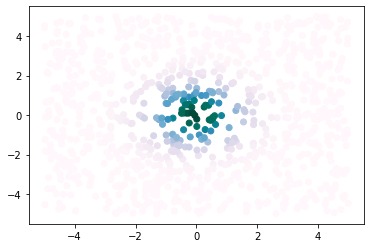

In [270]:
plt.scatter( thetaPrior[:, 0], thetaPrior[:, 1], c=plt.cm.PuBuGn(p_thetaPrior/p_thetaPrior.max()) )
plt.show()
plt.close('all')

In [317]:
p_y_log

array([ -71751.08814747,  -50623.13388089,  -70496.64329038,
       -138289.96985149, -133880.25361252,  -83199.95448189,
        -66179.8731481 , -208220.43572046,  -93939.65112172,
       -120275.82857382, -105578.6335925 , -140395.15739288,
       -185355.30593126, -119495.4082039 ,  -47993.9456989 ,
        -43815.45107384,  -54241.27476567, -111773.74244357,
       -107865.6164697 ,  -70931.38190587,  -84052.00892374,
       -194572.08281976,  -83387.76261208,  -83756.98695312,
       -174717.38135538, -128864.81997766, -206288.72646198,
        -66349.84455246,  -12801.44091403, -143685.51266556,
        -30373.4897161 ,  -25697.00242146,  -89334.05293871,
       -112319.32089161,  -84736.88553038,  -93626.06739759,
        -35756.23844737,  -83346.3285998 , -103514.71658039,
       -102305.8069826 , -103725.33922331,  -68462.6925824 ,
        -88968.92803936, -100054.27840986, -144363.80447461,
       -117938.34281261,  -91288.08752804, -134662.38674752,
       -104311.31904757,

In [279]:
thetaPrior

array([[-4.91596744,  4.64797023],
       [ 0.62097812,  1.27408722],
       [-2.4911255 ,  4.08736893],
       ...,
       [ 3.88125062, -0.04861796],
       [-1.01044654, -1.63982577],
       [ 4.78886518,  0.72225063]])